# CHAPTER 7. 비선형 회귀 모델

- 신경망모델, 다변량 적응 회귀 스플라인(MARS), 서포트 벡터머신(SVM), KNN

In [4]:
library(AppliedPredictiveModeling)
data(solubility)

library(caret)
set.seed(100)
indx <- createFolds(solTrainY, returnTrain = TRUE,k = 5)
ctrl <- trainControl(method = "cv", index = indx)

Loading required package: lattice
Loading required package: ggplot2


## 1. 신경망 모델

- 뇌의 작동 방식에 대한 이론에서 영향을 받은 강력한 비선형 회귀 기법


- 결과 값은 관측되지 않은 변수에 대한 중간값의 세트 형태로 만들어진다(은닉 변수, 은닉 단위)


- 은닉 단위는 **원 예측 변수의 선형 조합**으로 만들어지지만 이 값이 수직적 형태로 추정되지는 않는다.


- 은닉 단위는 **일부 또는 전 예측 변수의 선형 조합**이다.


- 선형 조합은 일반적으로 비선형 함수로 로지스틱(시그모이드) 함수 같은 것이 사용된다.


- 신경망 모델은 보통 결과값까지 도달하는 데 여러 은닉 단위를 포함시킨다.


- 은닉 단위의 개수가 정의되면 각 단위는 결과와 연관된다.


- 다른 선형 조합은 결과에 연관된 은닉 단위를 연결할 것이다.


- H개의 은닉 단위, P개의 예측 변수 유형인 경우, **H(P+1)+H+1 개의 수**를 추정하게 된다.


- 인수 최적화는 회귀 모델로 친다면 잔차 제곱합을 최소화 하는 식으로 진행된다.


- **역전파 알고리즘(Back-Propagation)** : 최적 인수를 찾기 위한 방법, 인수를 임의의수로 초기화한 후 방정식을 푸는 특별한 알고리즘


- 하지만 위 방정식의 해법은 보통 **전역 해법이 아니다**. 


- 신경망은 회귀 계수가 커짐에 따라 **예측 변수와 응답 변수 간의 관계를 과적합** 시키는 경향이 있다.


- 과적합 문제를 해결하기 위한 방법

    - **조기 정지 방식** : 회귀 방정식을 풀기 위한 반복 알고리즘을 보다 빠르게 멈추는 것(몇몇 오차율 추정값이 증가하기 시작하면 최적화 과정을 멈춘다)
    
    - **가중값 감소** : 벌점 방식을 사용해 능형 회귀처럼 모델을 정규화하는 것
    
    
- 신경망 모델 구조

    - 단일층 피드 포워드 망 : 가장 단순한 신경망 모델 구조
    
    - 층 간에 양방향으로 반복적으로 오가는 형태
    
    - 베이지안적 접근(Neal, 1996) : 자동 정규화와 자동 특징 선택을 포함
    
    
- 자기 조직화 지도 (Self-Organizing Map) : 신경망과 매우 유사한 모델로 비지도식 탐색적 접근방법에 사용하거나 예측 시 지도적 방식으로 사용


- **모델 평균 방식** : 보다 안정적인 예측 값을 생성하기 위해 서로 다른 시작 값을 만든 후 이에 대한 결과의 평균을 내는 방식

    - 하지만 때때로 예측변수들 간의 높은 상관성을 만들기도 함
    
    - 높은 상관 관계가 있는 변수를 사전에 제거
    
    - 주성분 분석과 같은 특징 추출 기법을 모델링 전에 사용함으로써 상관관계 문제를 제거

In [ ]:
library(doParallel)
registerDoParallel(3)

nnetGrid <- expand.grid(decay = c(0, 0.01, .1), 
                        size = c(7, 9, 11, 13), 
                        bag = FALSE)

In [ ]:
# 실행시간이 너무 오래걸림
#set.seed(100)
#nnetTune <- train(x = solTrainXtrans, y = solTrainY,
#                  method = "avNNet",
#                  tuneGrid = nnetGrid,
#                  trControl = ctrl,
#                  preProc = c("center", "scale"),
#                  linout = TRUE,
#                  trace = FALSE,
#                  MaxNWts = 13 * (ncol(solTrainXtrans) + 1) + 13 + 1,
#                  maxit = 300,
#                  allowParallel = FALSE)
#nnetTune

## 2. 다변량 가법 회귀 스플라인 모델 (Multivariate Adaptive Regression Splines, MARS)

- MARS는 모델에 사용하는 예측 변수를 두 가지 상반된 형태로 만든다. 


- MARS에서 원변수 대신 사용되는 요소는 보통 한 번에 예측 변수 한두개가 사용되는 함수


- 예측 변수를 두 그룹으로 나누어 각 그룹에 대해 예측 변수와 결과 값의 선형 조합을 모델링하는 특성


- 예측 변수에 대해 구분점을 줌

    - "좌측" 요소는 구분점보다 조금이라도 큰 값
    - "우측" 요소는 구분점보다 조금이라도 작은 요소를 포함
    
    
- 이러한 새 요소들을 기본 선형 회귀 모델에 추가해 기울기와 절편을 추정 (구간별 선형 모델)


- 후보 요소들에 대해 선형 회귀 모델을 만들어 후보 구분점을 만들고 각 예측 변수에 대한 모델 오차를 구해 최소 오차를 내는 예측변수/구분점 조합을 사용한다.


- 전체 요소가 생성되면, 알고리즘은 모델 방정식에 유의한 영향을 미치지 못하는 개별 요소를 순차적으로 제거
    - 오차율이 얼마나 줄어드는지를 추정해 평가
    - 각 요소의 기여도를 판단할 때는 GCV 통계량을 사용한다. (1개의 값을 남겨 두는 식의 교차 검증식을 추정해 오차값을 구하는 선형 회귀 모델의 계산 형태 단축키와 같다.)
    
        
- MARS 모델에서는 2개의 튜닝 변수 존재
    - 모델에 더해지는 요소의 차수
    - 남아 있는 항의 수
    
    
- GCV 추정값은 교차 검증 과정이나 테스트 세트를 사용해 구한 값보다 긍정적으로 나타난다.


- GCV 추정값은 특정 선택상에서 야기 될 수 있는 편향적 선택으로 인한 불확실성을 반영하지 않는다.


- MARS 모델의 이점

    - 자동으로 특징 선택
    - 해석력이 좋다
    - 데이터 전처리가 필요 없다.

In [1]:
install.packages("earth")

package 'earth' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\student\AppData\Local\Temp\RtmpQpcJtM\downloaded_packages


In [2]:
library(earth)

Loading required package: plotmo
Loading required package: plotrix
Loading required package: TeachingDemos


In [5]:
set.seed(100)
marsTune <- train(x = solTrainXtrans, y = solTrainY,
                  method = "earth",
                  tuneGrid = expand.grid(degree = 1, nprune = 2:38),
                  trControl = ctrl)

In [6]:
marsTune 

Multivariate Adaptive Regression Spline 

951 samples
228 predictors

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 761, 760, 761, 761, 761 
Resampling results across tuning parameters:

  nprune  RMSE       Rsquared   MAE      
   2      1.5595264  0.4202027  1.1948169
   3      1.1591558  0.6834014  0.8920263
   4      1.0584122  0.7359689  0.8126383
   5      0.9768069  0.7757225  0.7372216
   6      0.9283871  0.7962609  0.7174837
   7      0.8828474  0.8147141  0.6839234
   8      0.8502673  0.8287534  0.6561488
   9      0.8329771  0.8354348  0.6400454
  10      0.8311301  0.8358872  0.6330869
  11      0.8217081  0.8393627  0.6292012
  12      0.8030232  0.8470235  0.6168000
  13      0.8044696  0.8457460  0.6162010
  14      0.7920158  0.8510205  0.6073237
  15      0.7795147  0.8556656  0.5981200
  16      0.7738916  0.8575841  0.5932756
  17      0.7635393  0.8613300  0.5816250
  18      0.7535606  0.8647233  0.5736953
  19      0.7457972  

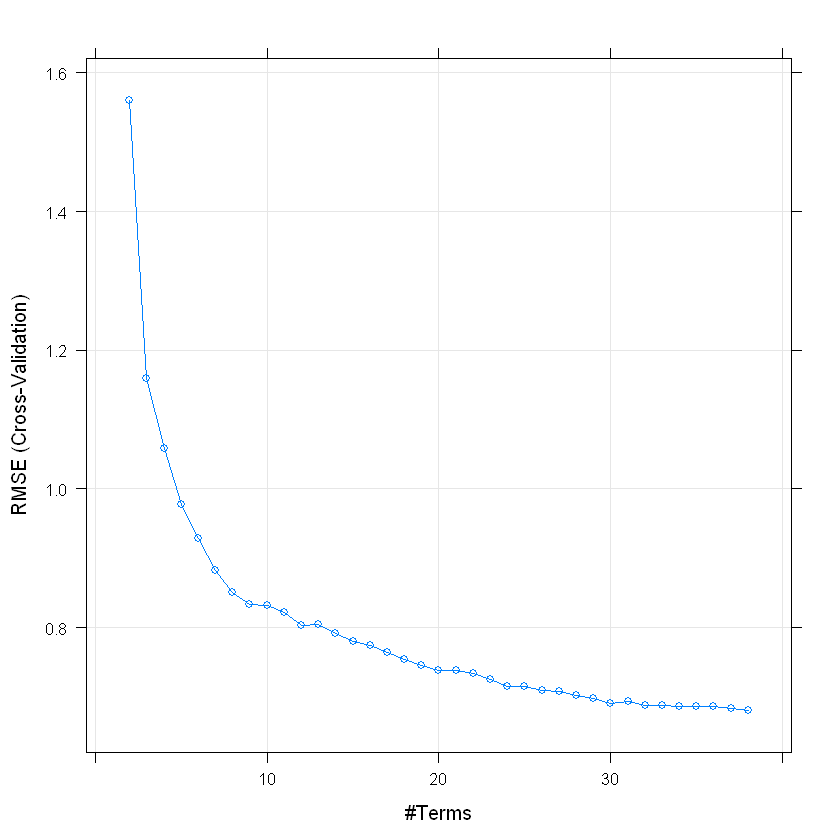

In [7]:
win.graph()
plot(marsTune)

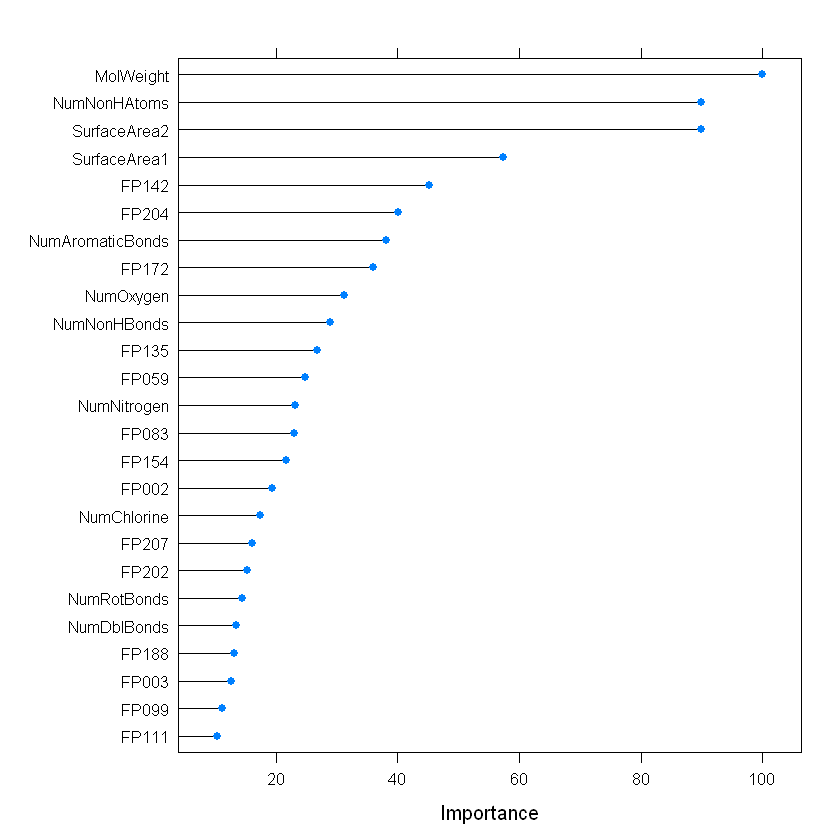

In [8]:
marsImp <- varImp(marsTune, scale = FALSE)
plot(marsImp, top = 25)

## 3. 서포트 벡터 머신

- 강력하고 유연성 높은 모델링 기법


- $\epsilon$ - 불감성회귀(insensitive regression) 을 대표 유형으로 살펴봄


- 선형회귀에서 SSE를 최소화 하는 경우 문제점 : 전체 데이터 추세와 떨어진 관측치에 영향을 많이 받는다.


- 회귀를 사용하는 SVM은 후버 함수와 비슷한 함수를 사용하지만, 사용자가 정한 수치($\epsilon$)가 주어졌을 때, 임계점 내에 잔차가 있는 데이터 포인트는 회귀 최적화에 영향을 미치지 않지만, 임계점과의 절대 차가 큰 데이터 포인트는 모델에 선형 영향을 미칠 수 있다.


- 주요 특징

    * 잔차 제곱을 사용하지 않으므로 큰 이상값이 회귀 방정식에 미칠 수 있는 효과가 한정적이다.
    
    * 모델에 잘 맞는 샘플은(잔차가 작은 샘플) 회귀 방정식에 전혀 영향을 미치지 않는다. (임계값이 충분히 큰 수로 설정됐다면, 회귀선을 정의하는 데 영향을 미치는 것은 이상값 뿐이다.)
    
    
- 선형 서포트 벡터 머신의 예측함수

    * 데이터 포인트 만큼 많은 인수가 존재 : 과하게 매개변수화돼 있는 경향이 있다.
    
    * 새 예측 모델에는 개별 훈련 데이터 세트의 데이터가 필요하다.
    
    * 훈련 세트가 크다면 예측 방정식이 다른 기법보다 다소 복잡해질 수 있다.
    
    
- 커널 트릭 : 비선형 모델을 설명하기 위해 적용하는 함수

    * 다항 함수
    
    * 방사형 기반 함수
    
    * 쌍곡 탄젠트
    
    
- 비용 변수 : 모델의 복잡도를 측정하는 대표적인 수단

    * 비용이 커지면 모델은 매우 유연해지지만, 오차 효과는 증폭된다.
    
    * 비용이 작은 경우, 모델은 경직이 오며 과적합으로 가는 경향이 낮아진다.
    
    
- 예측 변수 척도 차이가 모델에 영향을 미칠 수 있다. : SVM 모델을 만들기 전에 예측변수에 먼저 중심화, 척도화를 한다.

In [10]:
set.seed(100)
svmRTune <- train(x = solTrainXtrans, y = solTrainY,
                  method = "svmRadial",
                  preProc = c("center", "scale"),
                  tuneLength = 14,
                  trControl = ctrl)

In [11]:
svmRTune

Support Vector Machines with Radial Basis Function Kernel 

951 samples
228 predictors

Pre-processing: centered (228), scaled (228) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 761, 760, 761, 761, 761 
Resampling results across tuning parameters:

  C        RMSE       Rsquared   MAE      
     0.25  0.8248881  0.8601954  0.6154980
     0.50  0.7245026  0.8837766  0.5414887
     1.00  0.6711897  0.8966632  0.4977384
     2.00  0.6370451  0.9051702  0.4689804
     4.00  0.6222739  0.9085952  0.4559337
     8.00  0.6077654  0.9121311  0.4461431
    16.00  0.6022351  0.9134520  0.4434838
    32.00  0.6016155  0.9133892  0.4441202
    64.00  0.5991967  0.9138120  0.4431945
   128.00  0.6000175  0.9135433  0.4440183
   256.00  0.6026872  0.9129046  0.4465660
   512.00  0.6065498  0.9118377  0.4491954
  1024.00  0.6082919  0.9111903  0.4511546
  2048.00  0.6132265  0.9095552  0.4558016

Tuning parameter 'sigma' was held constant at a value of 0.002762998
RMSE was used to

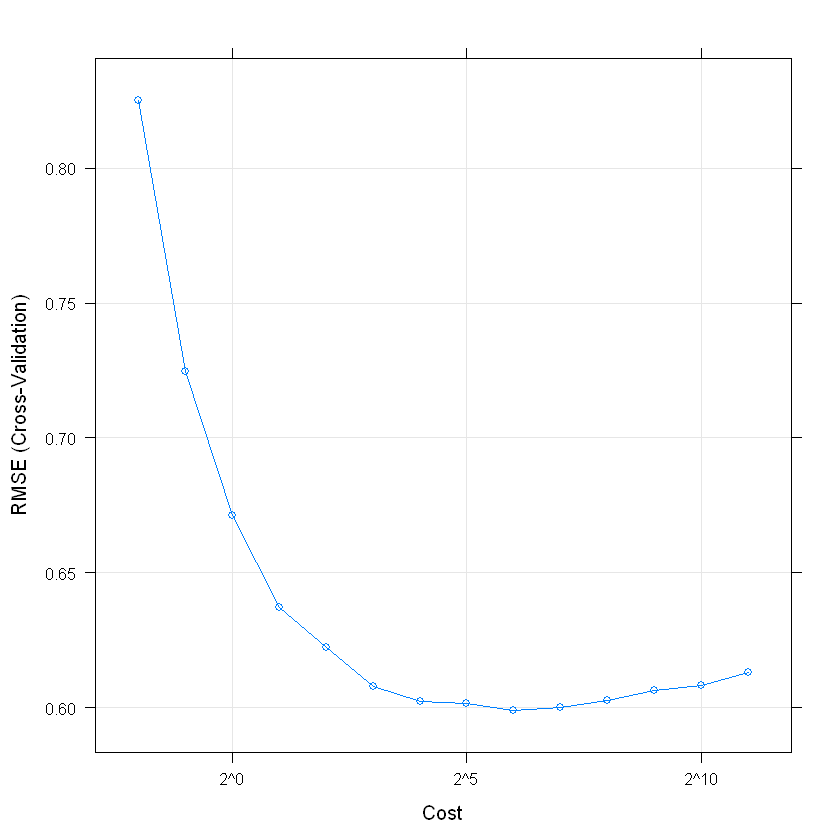

In [12]:
win.graph()
plot(svmRTune, scales = list(x = list(log = 2)))

In [13]:
svmGrid <- expand.grid(degree = 1:2, 
                       scale = c(0.01, 0.005, 0.001), 
                       C = 2^(-2:5))
set.seed(100)
svmPTune <- train(x = solTrainXtrans, y = solTrainY,
                  method = "svmPoly",
                  preProc = c("center", "scale"),
                  tuneGrid = svmGrid,
                  trControl = ctrl)

svmPTune

Support Vector Machines with Polynomial Kernel 

951 samples
228 predictors

Pre-processing: centered (228), scaled (228) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 761, 760, 761, 761, 761 
Resampling results across tuning parameters:

  degree  scale  C      RMSE       Rsquared   MAE      
  1       0.001   0.25  1.0845844  0.7863696  0.8077434
  1       0.001   0.50  0.9137700  0.8300626  0.6843657
  1       0.001   1.00  0.8068253  0.8546090  0.6096483
  1       0.001   2.00  0.7462479  0.8708883  0.5648285
  1       0.001   4.00  0.7145833  0.8796925  0.5441948
  1       0.001   8.00  0.7025231  0.8829041  0.5305937
  1       0.001  16.00  0.6981953  0.8840583  0.5256058
  1       0.001  32.00  0.7085775  0.8810265  0.5305869
  1       0.005   0.25  0.7843026  0.8606588  0.5930705
  1       0.005   0.50  0.7335103  0.8743445  0.5561220
  1       0.005   1.00  0.7082002  0.8813549  0.5379899
  1       0.005   2.00  0.6997018  0.8837158  0.5278384
  1       0.00

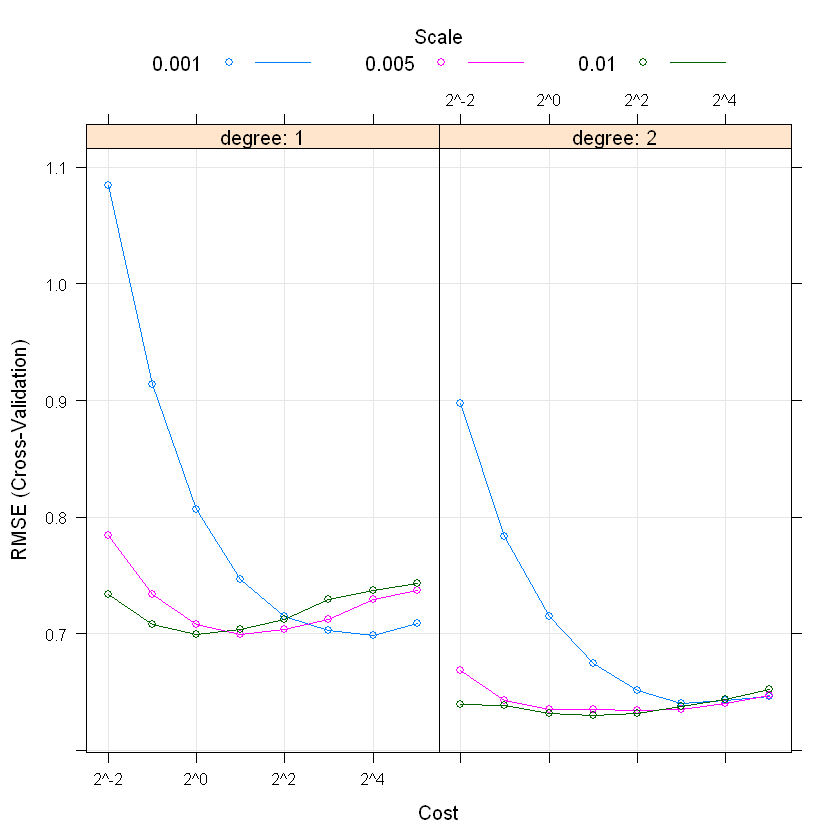

In [14]:
plot(svmPTune, 
     scales = list(x = list(log = 2), 
                   between = list(x = .5, y = 1)))

## 4. K-최근접 이웃


- 훈련 세트에서 K개의 가장 근접한 샘플을 사용해 새로운 샘플에 대해 예측


- 새 샘플에 대해 예측된 응답값은 **K개의 이웃 응답값의 평균**이 된다.


- 샘플간의 거리를 정의하는 다양한 거리 척도가 존재한다.

    - **유클리드 거리(일반적)**, 민코프스키 거리, 맨하탄거리, 타니모토거리, 해밍거리, 코사인거리
    

- 예측 변수의 척도가 샘플 간 거리에 엄청난 영향을 미친다 (중심화, 척도화 중요)


- 예측 변숫값이 누락된 경우

    - 해당 샘플이나 해당 예측 변수 제거(비추천)
    
    - 결측값을 대치하는 방법(평균, 최근접이웃방법)
    
    
- 최적 이웃 수를 찾는 과정

    - K가 작은 경우 과적합 위험
    
    - K가 큰 경우 과소 적합 위험
    
    
    
- KNN의 대표 문제점

    - **계산 시간 문제**
    
    - **지역 예측 변수 구조가 응답 변수와 연관이 없는 경우**, 예측 성능이 낮을 수 있다.
    
        - 연관이 없거나 잡음이 많은 예측 변수를 제거하는 것이 KNN에서 핵심 전처리 단계
    

In [18]:
knnDescr <- solTrainXtrans[, -nearZeroVar(solTrainXtrans)]

set.seed(100)
knnTune <- train(x = knnDescr, y = solTrainY,
                 method = "knn",
                 preProc = c("center", "scale"),
                 tuneGrid = data.frame(k = 1:20),
                 trControl = ctrl)
                 
knnTune

k-Nearest Neighbors 

951 samples
225 predictors

Pre-processing: centered (225), scaled (225) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 761, 760, 761, 761, 761 
Resampling results across tuning parameters:

  k   RMSE      Rsquared   MAE      
   1  1.249349  0.6662674  0.9090411
   2  1.122184  0.7123104  0.8331762
   3  1.073073  0.7321346  0.8067870
   4  1.063817  0.7354431  0.8033362
   5  1.050724  0.7409876  0.7968576
   6  1.057909  0.7363694  0.8010092
   7  1.061477  0.7342560  0.8052975
   8  1.059673  0.7357443  0.8104108
   9  1.061077  0.7349370  0.8139727
  10  1.065152  0.7329029  0.8212679
  11  1.076053  0.7268769  0.8291165
  12  1.089116  0.7201702  0.8372358
  13  1.095273  0.7170472  0.8437487
  14  1.106196  0.7110973  0.8550969
  15  1.114415  0.7067800  0.8626821
  16  1.122283  0.7029098  0.8719824
  17  1.123285  0.7028894  0.8734794
  18  1.130152  0.7001038  0.8788007
  19  1.135755  0.6970880  0.8840846
  20  1.146207  0.6914133  0.

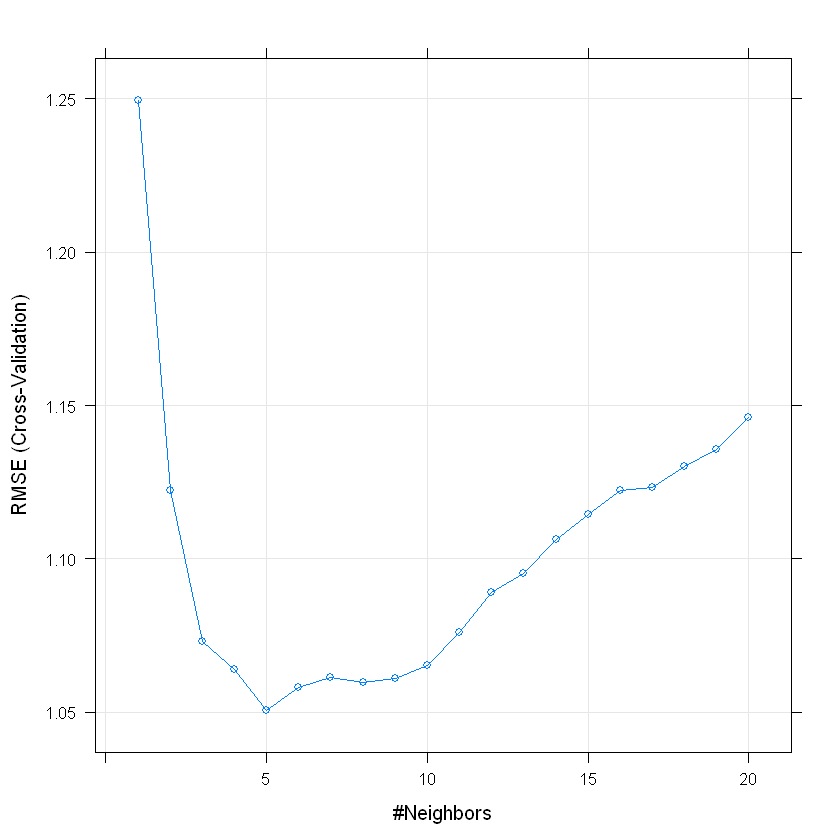

In [19]:
win.graph()
plot(knnTune)